## Statistical modeling of the association of Divergent Fungal Actin (DFA) and fungal trait

**Notebook summary**

This Jupyter Notebook:
- is part of the last step of the project: Statistical modeling of the association of DFA and fungal trait
- tests the association of DFA presence/absence and previoulsy curated fungal traits
- visualizes the distribution of data for each trait (Figure 6)


**Context/Goal reminder**
We aim to test for any sigificant association between the presence/absence of Divergent Fungal Actin (DFA) and specific fungal traits in order to make hypothesis about the function of DFA. We fit different models for each trait.
Presence/absence of DFA is a binary variable and fungal traits are either binary (auxin responsive promoter), continuous (spore length and spore width) or discrete variables (Ascus dehiscence, growth form and trophic mode).



**Notebook purpose**
In this notebook, we visualize the distribution of the data for each trait and run statistical modeling to test for the association between DFA and fungal traits.
For continuous traits, we use phylogeny-corrected generalized linear mixed models (pglmm) to identify if the trait is a predictor of the DFA presence/absence status. For binary and discrete traits, we used an evolutionary model selection procedure. We fit two alternative models to the data, one where DFA and the trait of interest were assumed to have co-evolved and a second model where DFA and the trait of interest were assumed to have evolved independently. We then compare the likelihood of these models using the Akaike information criterion (AIC), a measure of model likelihood that is penalized for model complexity. This same model selection procedure is used for two classes of models, a discrete-time Markov model (DTMM) and a hidden Markov model (HMM), both used extensively in modeling the evolution of discrete traits across time. These tests are part of the R corHMM package (https://doi.org/10.1093/sysbio/syt034).  

---

### Setup path and environment

In [1]:
setwd('..')

options(warn=-1) # prevents warnings from being display change to options(warn=0) if you wan to get the warnings displayed


library(ape)
library(ggtree)
library(ggplot2)
library(tidyverse)
library(corHMM)
library(phyr)

Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

ggtree v3.6.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published rese

### Function definition

In [2]:
## Function 1
 # This function reformats the output of the corHMM::fitCorrelationTest test into a dataframe in which, for each fitted models, we store information about model, rate.cat, loglik, AIC and AUCc

cor_mod_res=function(fsa_asc_corr_test){

  corhmm_res <- data.frame(
    model = names(fsa_asc_corr_test),
    n_rate_cats = NA,
    n_params = NA,
    neg_log_lik = NA,
    AIC = NA,
    AICc = NA
  )
  for(model in 1:length(ls(fsa_asc_corr_test))){
    mod_name <- names(fsa_asc_corr_test[model])
    mod_cats <- fsa_asc_corr_test[[model]]$rate.cat
    mod_nparam <- length(na.omit(c(fsa_asc_corr_test[[model]]$solution)))
    mod_lik <- round(fsa_asc_corr_test[[model]]$loglik, 2)
    mod_aic <- round(fsa_asc_corr_test[[model]]$AIC, 2)
    mod_aicc <- round(fsa_asc_corr_test[[model]]$AICc, 2)
  
    corhmm_res[model,] <-
      c(mod_name, mod_cats, mod_nparam,
        mod_lik, mod_aic, mod_aicc)
  }

  corhmm_res
}

### Analysis

In [3]:
## Data import

data_trait_all=read.csv('data/step4/traits_DFA_info_col.csv')[-1]
tree_all=read.tree('data/step3/species_trait_tree_final.nwk')

## Only keep trait information for species that have phylogeny information

species_G=intersect(data_trait_all$tip.label, tree_all$tip.label)

data_trait_all_g=subset(data_trait_all, data_trait_all$tip.label%in%species_G)

In [4]:
colnames(data_trait_all_g)

[1] "tip.label"                     "Phylum"                       
[3] "DFA"                           "ascus_dehiscence"             
[5] "auxinResponsivePromoter_count" "growth_form_fg"               
[7] "spore_length"                  "spore_width"                  
[9] "trophic_mode_fg"

In [5]:
head(data_trait_all_g,10)

,tip.label,Phylum,DFA,ascus_dehiscence,auxinResponsivePromoter_count,growth_form_fg,spore_length,spore_width,trophic_mode_fg
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
1,Agaricus_bisporus,Basidiomycota,No,NA,NA,NA,9,6.55,NA
2,Amanita_muscaria,Basidiomycota,Yes,NA,0,Agaricoid,9,6.50,Symbiotroph
4,Armillaria_gallica,Basidiomycota,Yes,NA,NA,Agaricoid,NA,NA,Pathotroph-Saprotroph
5,Armillaria_ostoyae,Basidiomycota,Yes,NA,NA,Agaricoid,9,5.50,Pathotroph-Saprotroph
8,Aspergillus_clavatus,Ascomycota,Yes,NA,0,Microfungus,NA,NA,Pathotroph
9,Aspergillus_flavus,Ascomycota,No,NA,0,Microfungus,NA,NA,Pathotroph-Saprotroph
11,Aspergillus_ruber,Ascomycota,No,NA,0,Microfungus,NA,NA,Pathotroph
13,Beauveria_bassiana,Ascomycota,No,NA,0,NULL,NA,NA,Pathotroph
16,Bipolaris_oryzae,Ascomycota,Yes,NA,0,NULL,NA,NA,Pathotroph


#### Trait 1: Ascus dehiscence

In [6]:
  ##extracting and preparing the data for the model
data_trait1=data_trait_all[,c('tip.label','DFA','ascus_dehiscence')]%>%na.omit()

data_ex=data_trait1
  
  ##keep only levels with 4 or more counts

trait_counts=data.frame(t(table(data_ex$ascus_dehiscence)))[,-1]
colnames(trait_counts)=c('trait_lev','count')
good_traits=subset(trait_counts, trait_counts$count>=4)

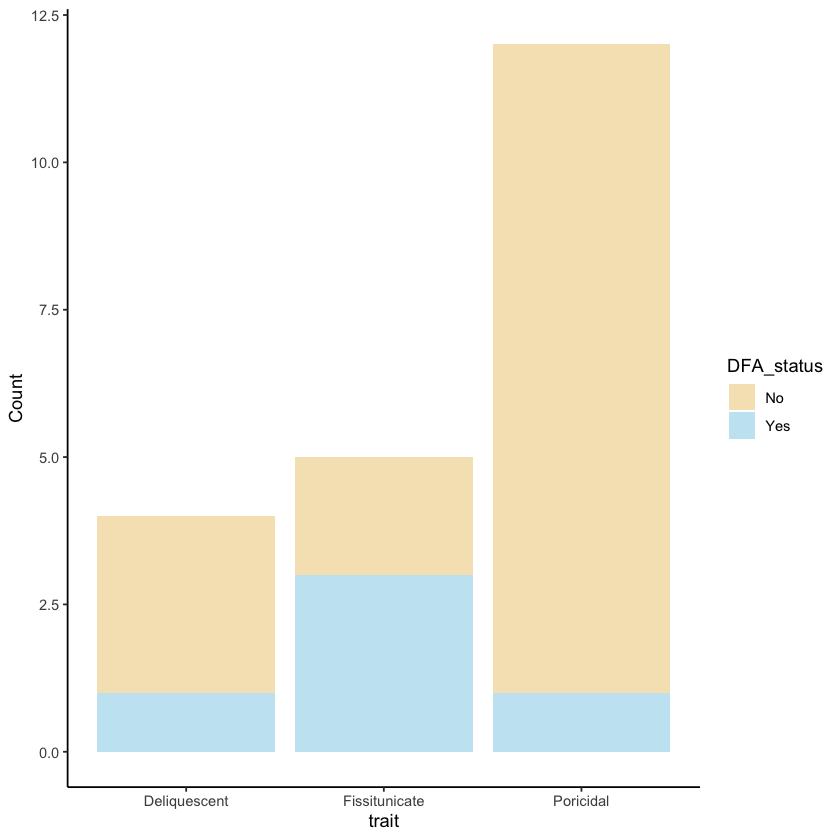

In [7]:
## data visualization
traits_lev=c(unique(good_traits$trait_lev))
data_viz=data.frame()

for (i in 1:length(traits_lev)){
  dat=subset(data_ex, data_ex$ascus_dehiscence==traits_lev[i])
  DFA_yes=length(which(dat$DFA=='Yes'))
  DFA_no=length(which(dat$DFA=='No'))
  dat_tp=data.frame('trait'=traits_lev[i],'Yes'=DFA_yes,'No'=DFA_no)
  data_viz=rbind(data_viz,dat_tp)
}

data_plot=gather(data_viz,DFA_status,Count,Yes:No)

plot=ggplot(data_plot, aes(x=trait, y=Count,fill=DFA_status)) + geom_bar(stat='identity')+
  theme_classic() + scale_fill_manual(values=c('#F5E4BE','#C6E7F4'))

plot


In [8]:
  ## subset data for levels with enough counts

data_model=subset(data_ex, data_ex$ascus_dehiscence%in%traits_lev)


##trimming tree to keep the right tips

tree_tip=intersect(tree_all$tip.label,data_model$tip.label)
tree_pruned=keep.tip(tree_all, tree_tip)


In [9]:
  ## Modeling

dat=data_model

   # Reformat DFA as a binary presence/absence
dat$DFA <- as.factor(gsub(1, "Present", dat$DFA) |> gsub(pattern = 0, replacement = "Absent"))

   # Add a column to have trait as a factor
dat$ascD <- dat$ascus_dehiscence
dat$ascD <- as.factor(dat$ascD)

  # Sort data to match tip labels
tree = tree_pruned
dat <- dat[match(tree$tip.label, dat$tip.label),]

   # Fit models
fsa_asc_corr_test <-
  corHMM::fitCorrelationTest(tree,
                             data = dat[c('tip.label', 'DFA', 'ascD')])


Begining test of correlation...

Fitting an independent model...
Fitting a hidden Markov independent model...
Fitting a correlated model...
Fitting a hidden Markov correlated model...
Done.


In [10]:
 # Format model output 

cor_asd=cor_mod_res(fsa_asc_corr_test)

cor_asd

model,n_rate_cats,n_params,neg_log_lik,AIC,AICc
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
independent_model_fit,1,18,-14.62,45.24,74.04
hidden_Markov_independent_model_fit,2,48,-14.05,64.1,-72.7
correlated_model_fit,1,18,-13.78,63.56,-73.24
hidden_Markov_correlated_model_fit,2,48,-13.7,103.4,-15.16


#### Trait 2: Growth form

In [8]:
    ##extracting and preparing the data for the model


data_trait2=data_trait_all[,c('tip.label','DFA','growth_form_fg')]%>%na.omit()
data_trait2=subset(data_trait2, data_trait2$growth_form_fg!='NULL') # Removes anything that has a 'NULL' tag as growth form


data_ex=data_trait2

data_ex$growth_form_fg[data_ex$growth_form_fg=='Facultative Yeast']<-'Yeast'  # Facultative yeast is counted as yeast


##keep only levels with 4 or more counts

trait_counts=data.frame(t(table(data_ex$growth_form_fg)))[,-1]
colnames(trait_counts)=c('trait_lev','count')
good_traits=subset(trait_counts, trait_counts$count>=4)


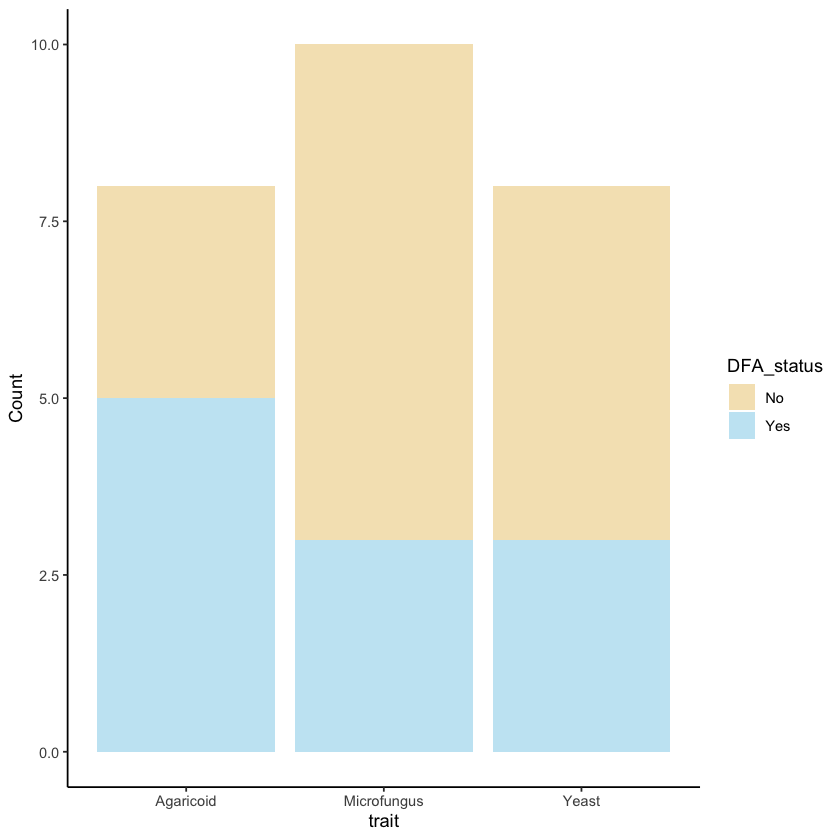

In [9]:
## data visualization
traits_lev=c(unique(good_traits$trait_lev))
data_viz=data.frame()

for (i in 1:length(traits_lev)){
  dat=subset(data_ex, data_ex$growth_form_fg==traits_lev[i])
  DFA_yes=length(which(dat$DFA=='Yes'))
  DFA_no=length(which(dat$DFA=='No'))
  dat_tp=data.frame('trait'=traits_lev[i],'Yes'=DFA_yes,'No'=DFA_no)
  data_viz=rbind(data_viz,dat_tp)
}

data_plot=gather(data_viz,DFA_status,Count,Yes:No)

plot=ggplot(data_plot, aes(x=trait, y=Count,fill=DFA_status)) + geom_bar(stat='identity')+
  theme_classic() + scale_fill_manual(values=c('#F5E4BE','#C6E7F4'))

plot


In [13]:
## subset data for good traits

data_model=subset(data_ex, data_ex$growth_form_fg%in%traits_lev)

##trimming tree to keep the right tips

tree_tip=intersect(tree_all$tip.label,data_model$tip.label)
tree_pruned=keep.tip(tree_all, tree_tip)

In [14]:
  ## Modeling

dat=data_model

   # Reformat DFA as a binary presence/absence
dat$DFA <- as.factor(gsub(1, "Present", dat$DFA) |> gsub(pattern = 0, replacement = "Absent"))

   # Add a column to have trait as a factor
dat$gf <- dat$growth_form_fg
dat$gf <- as.factor(dat$gf)

  # Sort data to match tip labels
tree = tree_pruned
dat <- dat[match(tree$tip.label, dat$tip.label),]

   # Fit models
fsa_gf_corr_test <-
  corHMM::fitCorrelationTest(tree,
                             data = dat[c('tip.label', 'DFA', 'gf')])


Begining test of correlation...

Fitting an independent model...
Fitting a hidden Markov independent model...
Fitting a correlated model...
Fitting a hidden Markov correlated model...
Done.


In [15]:
 # Format model output 

cor_fg=cor_mod_res(fsa_gf_corr_test)

cor_fg

model,n_rate_cats,n_params,neg_log_lik,AIC,AICc
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
independent_model_fit,1,18,-26.67,69.34,78.94
hidden_Markov_independent_model_fit,2,48,-25.56,87.13,223.93
correlated_model_fit,1,18,-25.32,86.65,223.45
hidden_Markov_correlated_model_fit,2,48,-25.28,126.56,-71.04


#### Trait 3: Spore length

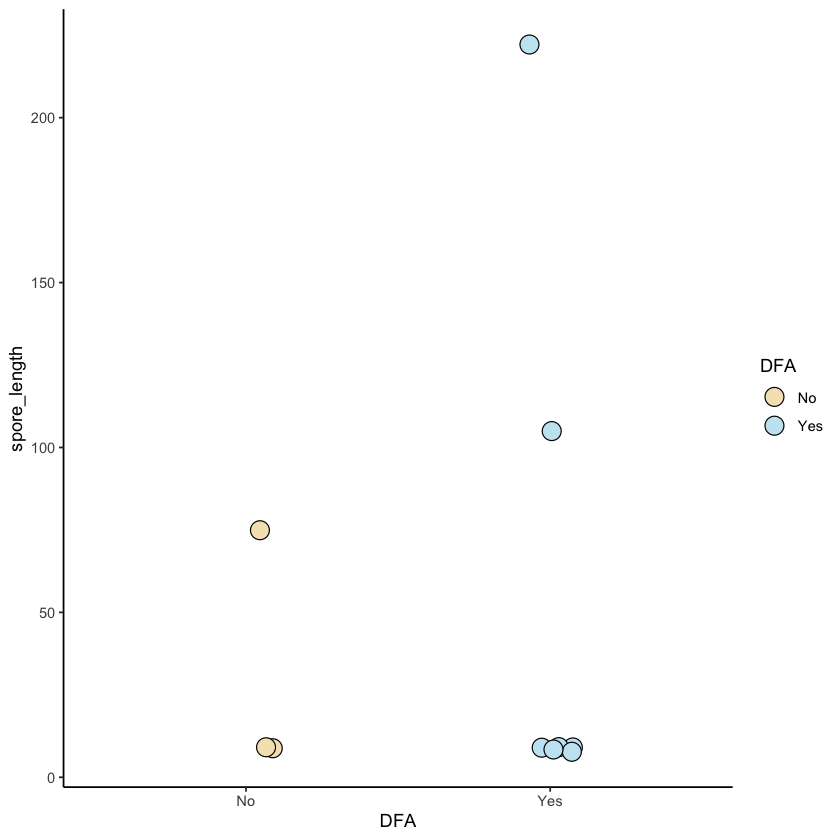

In [10]:
##extracting  the data (less reformating is necessary for continuous data)

data_trait3=data_trait_all_g[,c('tip.label','DFA','spore_length')]%>%na.omit()
data_ex=data_trait3


## data visualization

plot=ggplot(data_ex, aes(x=DFA, y=spore_length, fill=DFA)) + geom_jitter(position=position_jitter(0.1),size=5,shape=21, col='black')+
  theme_classic() + scale_fill_manual(values=c('#F5E4BE','#C6E7F4'))

plot


In [17]:
 ## DFA data transformation into 1 and 0 (for pglmm models)

data_ex$DFA[data_ex$DFA=='Yes']=1
data_ex$DFA[data_ex$DFA=='No']=0
data_ex$DFA=as.numeric(data_ex$DFA)

data_model=data_ex
rownames(data_model)=data_model$tip.label #the tip.labels must be rownames for the pglmm_compare function


 ##trimming tree to keep the right tips

tree_tip=intersect(tree_all$tip.label,data_model$tip.label)
tree_pruned=keep.tip(tree_all, tree_tip)


In [18]:
## Modeling
 # Because this is a continuous variable, we only need to test one model

model_t0=pglmm_compare(DFA ~ spore_length , data = data_model, phy = tree_pruned, family = "binomial")
model_t0

'as(<matrix>, "dgTMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "TsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:FDA ~ spore_length

logLik    AIC    BIC 
 -5.81  19.62  16.25 

Phylogenetic random effects variance (s2):
   Variance Std.Dev
s2    1.391    1.18

Fixed effects:
                Value Std.Error Zscore Pvalue
(Intercept)  0.027776  1.845217 0.0151 0.9880
spore_length 0.012707  0.022108 0.5748 0.5654


#### Trait 4: Spore width

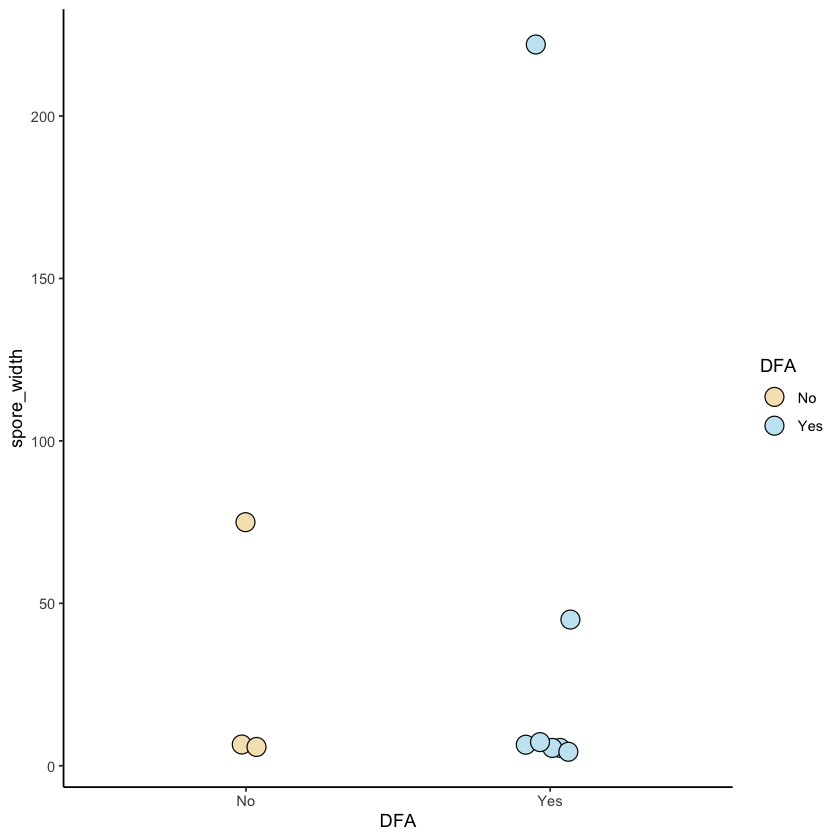

In [11]:
 ##extracting  the data (less reformating is necessary for continuous data)

data_trait4=data_trait_all_g[,c('tip.label','DFA','spore_width')]%>%na.omit()

data_ex=data_trait4


## data visualization

plot=ggplot(data_ex, aes(x=DFA, y=spore_width, fill=DFA)) + geom_jitter(position=position_jitter(0.1), size=5,shape=21,col='black')+
  theme_classic() + scale_fill_manual(values=c('#F5E4BE','#C6E7F4'))

plot


In [20]:
## DFA data transformation into 1 and 0 (for pglmm models)

data_ex$DFA[data_ex$DFA=='Yes']=1
data_ex$DFA[data_ex$DFA=='No']=0
data_ex$DFA=as.numeric(data_ex$DFA)

data_model=data_ex
rownames(data_model)=data_model$tip.label #the tip.labels must be rownames for the pglmm_compare function

##trimming tree to keep the right tips

tree_tip=intersect(tree_all$tip.label,data_model$tip.label)
tree_pruned=keep.tip(tree_all, tree_tip)


In [21]:
## Modeling

model_t0=pglmm_compare(DFA ~ spore_width , data = data_model, phy = tree_pruned, family = "binomial")
model_t0

Generalized linear mixed model for binomial data fit by restricted maximum likelihood

Call:FDA ~ spore_width

logLik    AIC    BIC 
-6.036 20.072 16.703 

Phylogenetic random effects variance (s2):
   Variance Std.Dev
s2   0.5502  0.7418

Fixed effects:
                Value Std.Error Zscore Pvalue
(Intercept) 0.5462263 1.2420472 0.4398 0.6601
spore_width 0.0054479 0.0155198 0.3510 0.7256


#### Trait 5: Trophic mode

In [12]:
 ##extracting and preparing the data for the model
data_trait5=data_trait_all_g[,c('tip.label','DFA','trophic_mode_fg')]%>%na.omit()

 #parsing and reorganizing data as single levels

levels=c('Symbiotroph','Saprotroph','Pathotroph')

data_troph_simp=data.frame()

for(i in 1:length(levels)){
  lev=levels[i]
  dat_temp=data_trait5[grep(lev,data_trait5$trophic_mode_fg),]
  
  colnames(dat_temp)=c('species','DFA','troph_mode')
  dat_temp$troph_mode=lev
  
  data_troph_simp=rbind(data_troph_simp, dat_temp)
  
}

data_ex=data_troph_simp

 #keeping only levels with 4 or more counts

trait_counts=data.frame(t(table(data_ex$troph_mode)))[,-1]
colnames(trait_counts)=c('trait_lev','count')
good_traits=subset(trait_counts, trait_counts$count>=4)


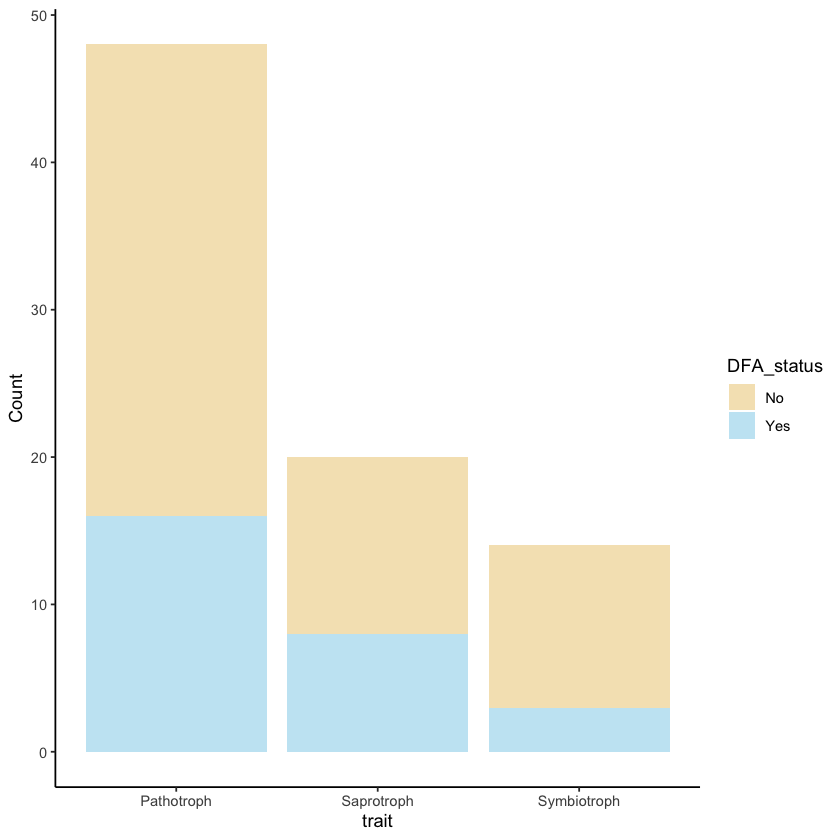

In [13]:
## data visualization
traits_lev=c(unique(good_traits$trait_lev))
data_viz=data.frame()

for (i in 1:length(traits_lev)){
  dat=subset(data_ex, data_ex$troph_mode==traits_lev[i])
  DFA_yes=length(which(dat$DFA=='Yes'))
  DFA_no=length(which(dat$DFA=='No'))
  dat_tp=data.frame('trait'=traits_lev[i],'Yes'=DFA_yes,'No'=DFA_no)
  data_viz=rbind(data_viz,dat_tp)
}

data_plot=gather(data_viz,DFA_status,Count,Yes:No)

plot=ggplot(data_plot, aes(x=trait, y=Count,fill=DFA_status)) + geom_bar(stat='identity')+
  theme_classic() + scale_fill_manual(values=c('#F5E4BE','#C6E7F4'))

plot


In [24]:
## subset data for good traits

data_model=subset(data_ex, data_ex$troph_mode%in%traits_lev)

##trimming tree to keep the right tips

tree_tip=intersect(tree_all$tip.label,data_model$species)
tree_pruned=keep.tip(tree_all, tree_tip)

In [25]:
 ## Modeling

dat=data_model
dat=subset(dat, dat$species%in%tree_tip)

   # Reformat DFA as a binary presence/absence
dat$DFA <- as.factor(gsub(1, "Present", dat$DFA) |> gsub(pattern = 0, replacement = "Absent"))

   # Add a column to have trait as a factor
dat$tm <- dat$troph_mode
dat$tm <- as.factor(dat$tm)

  # Sort data to match tip labels
tree = tree_pruned
dat <- dat[match(tree$tip.label, dat$species),]
colnames(dat)=c('tip.label',colnames(dat[,2:4]))

   # Fit models
fsa_tm_corr_test <-
  corHMM::fitCorrelationTest(tree,
                             data = dat[c('tip.label', 'DFA', 'tm')])


Begining test of correlation...

Fitting an independent model...
Fitting a hidden Markov independent model...
Fitting a correlated model...
Fitting a hidden Markov correlated model...
Done.


In [26]:
    # Format model output 
cor_tm=cor_mod_res(fsa_tm_corr_test)
cor_tm

model,n_rate_cats,n_params,neg_log_lik,AIC,AICc
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
independent_model_fit,1,18,-97.9,211.79,214.46
hidden_Markov_independent_model_fit,2,48,-93.16,222.31,237.86
correlated_model_fit,1,18,-94.21,224.42,239.96
hidden_Markov_correlated_model_fit,2,48,-92.43,260.86,384.36


#### Trait 6: Auxin responsive promoter

In [14]:
## extracting and reformating the data

data_trait6=data_trait_all_g[,c('tip.label','DFA','auxinResponsivePromoter_count')]%>%na.omit()

 #reorganizing auxin responsive promoter data as binary information (Yes & No)

data_trait6$auxinResponsivePromoter_count[data_trait6$auxinResponsivePromoter_count>=1]='Yes'
data_trait6$auxinResponsivePromoter_count[data_trait6$auxinResponsivePromoter_count==0]='No'

 #keep only levels with 4 or more counts
data_ex=data_trait6

trait_counts=data.frame(t(table(data_ex$auxinResponsivePromoter_count)))[,-1]
colnames(trait_counts)=c('trait_lev','count')
good_traits=subset(trait_counts, trait_counts$count>=4)

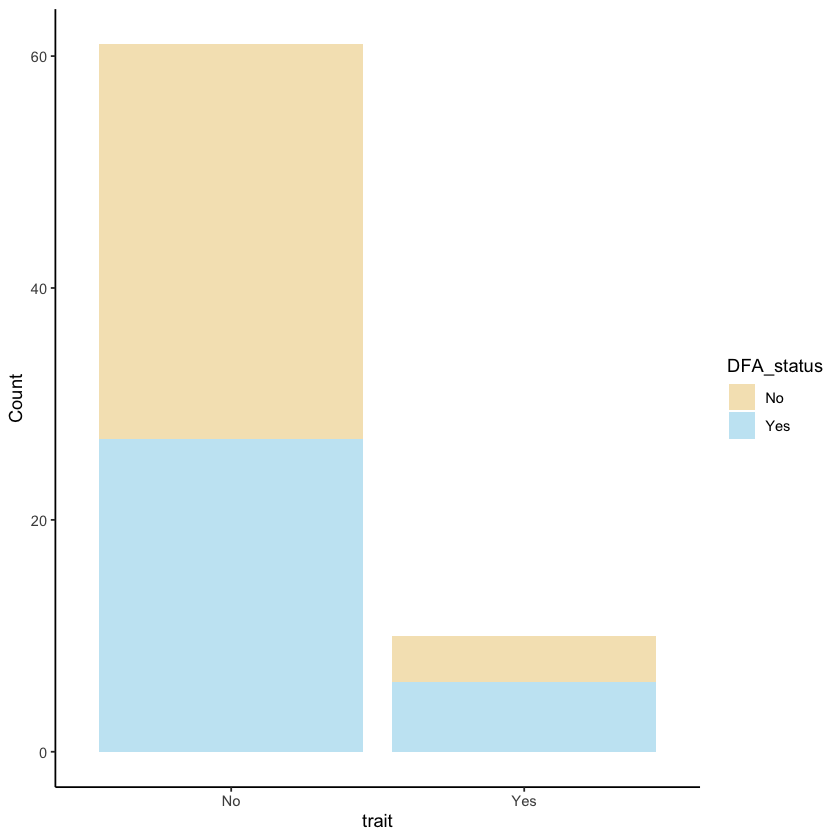

In [15]:
## data visualization
traits_lev=c(unique(good_traits$trait_lev))
data_viz=data.frame()

for (i in 1:length(traits_lev)){
  dat=subset(data_ex, data_ex$auxinResponsivePromoter_count==traits_lev[i])
  DFA_yes=length(which(dat$DFA=='Yes'))
  DFA_no=length(which(dat$DFA=='No'))
  dat_tp=data.frame('trait'=traits_lev[i],'Yes'=DFA_yes,'No'=DFA_no)
  data_viz=rbind(data_viz,dat_tp)
}

data_plot=gather(data_viz,DFA_status,Count,Yes:No)

plot=ggplot(data_plot, aes(x=trait, y=Count,fill=DFA_status)) + geom_bar(stat='identity')+
  theme_classic() + scale_fill_manual(values=c('#F5E4BE','#C6E7F4'))

plot


In [29]:
 ## Modeling

dat=data_trait6

 # Reformating data for corHMM model
dat$DFA <- as.factor(gsub("Yes", "Present", dat$DFA) |> gsub(pattern = "No", replacement = "Absent"))
dat$auxinResponsivePromoter <- dat$auxinResponsivePromoter_count
dat$auxinResponsivePromoter[which(dat$auxinResponsivePromoter == 'Yes')] <- "Present"
dat$auxinResponsivePromoter[which(dat$auxinResponsivePromoter == 'No')] <- "Absent"
dat$auxinResponsivePromoter <- as.factor(dat$auxinResponsivePromoter)

 # Prune the tree down to these species:
tree <- keep.tip(tree_all, dat$tip.label)

 # Sort data to match tip labels
dat <- dat[match(tree$tip.label, dat$tip.label),]

   # Fit models
dfa_aux_corr_test <-
  corHMM::fitCorrelationTest(tree,
                             data = dat[c('tip.label', 'DFA', 'auxinResponsivePromoter')])


Begining test of correlation...

Fitting an independent model...
Fitting a hidden Markov independent model...
Fitting a correlated model...
Fitting a hidden Markov correlated model...
Done.


In [30]:
##Format model output 

cor_arp=cor_mod_res(dfa_aux_corr_test)
cor_arp

model,n_rate_cats,n_params,neg_log_lik,AIC,AICc
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
independent_model_fit,1,8,-68.33,144.65,145.26
hidden_Markov_independent_model_fit,2,24,-62.8,145.6,149.27
correlated_model_fit,1,8,-66.47,148.94,151.26
hidden_Markov_correlated_model_fit,2,24,-62.15,160.29,173.45


In [31]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/manonmorin/miniconda3/envs/R_good_env/lib/libopenblasp-r0.3.24.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] phyr_1.1.2      corHMM_2.8      GenSA_1.1.10.1  nloptr_2.0.3   
 [5] forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4     purrr_1.0.2    
 [9] readr_2.1.4     tidyr_1.3.0     tibble_3.2.1    tidyverse_1.3.1
[13] ggplot2_3.4.4   ggtree_3.6.0    ape_5.7-1      

loaded via a namespace (and not attached):
  [1] nlme_3.1-163            fs_1.6.3                lubridate_1.9.3        
  [4] doParallel_1.0.17       httr_1.4.7              repr_1.1.6             
  [7] numDeriv_2016.8-1.1     tools_4.2.1             backports_1.4.1        
 [10] utf8_1.2.4              R6_2